<a href="https://colab.research.google.com/github/frederik-kilpinen/ASDS2/blob/main/image_classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification

In this notebook we train a convolutional neural network to classify images as either fire or koala. The notebook is structured as follows:

1. First we build a scraper to extract pictures of koalas and bush-fires and some other random noise.
2. We build a convolutional neural network

In [1]:
#Necessary Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
import tweepy
import pickle 
import time
import matplotlib.pyplot as plt
import requests as rq
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
#from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
import os


#from bing_image_downloader import downloader


## Get Twitter Images

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
image_tweets = pd.read_csv("/content/drive/MyDrive/Digital methods/image_tweets", index_col=0)
#Create list of image urls
image_urls = image_tweets["image_url"].unique()

In [14]:
def image_collect(urls):
    """
    This functions downloads images given a list of image urls.
    --------------------------------------------
    input: list of urls
    returns: images downloaded at specified path
    --------------------------------------------
    """
    import urllib.request
    idx = 0
    images = []
    path = "/content/drive/MyDrive/Digital methods/Images/"
    for url in tqdm(urls):
        response = urllib.request.urlretrieve(url, f"{path}img_{idx}.jpg")
        idx += 1

In [35]:
#Download all the tweet images
image_collect(image_urls[:100])

100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


In [37]:
###Preprocess the tweet images
images = []
for img in tqdm(os.listdir("/content/drive/MyDrive/Digital methods/Images/")):
    if img.endswith(".jpg"):
        path = f"/content/drive/MyDrive/Digital methods/Images/{img}"
        img=tf.keras.preprocessing.image.load_img(path, target_size=(299,299))
        img=tf.keras.preprocessing.image.img_to_array(img)
        images.append(img)

images = np.array(images)

100%|██████████| 100/100 [00:02<00:00, 43.57it/s]


In [26]:
images[0].shape

(299, 299, 3)

## Image classification using pre-trained Keras Xception

In [22]:
#load pre trained Xception model
model=tf.keras.applications.xception.Xception(weights='imagenet',include_top=True)

91889664/91884032 [==============================] - 1s 0us/step


In [31]:
import requests #fetching labels from Imagenet  
response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
imgnet_map=response.json()
imgnet_map={v[1]:k for k, v in imgnet_map.items()}#make model predictionsimg=tf.keras.applications.xception.preprocess_input(img)

40960/35363 [==================================] - 0s 0us/step


[[('n04149813', 'scoreboard', 0.9999949),
  ('n02666196', 'abacus', 4.698416e-06),
  ('n03775546', 'mixing_bowl', 2.1860573e-07),
  ('n03131574', 'crib', 2.0374276e-07),
  ('n02834397', 'bib', 2.4146814e-08)]]

In [45]:
#predictions=model.predict(np.array([images]))
#decode_predictions(predictions,top=5)

[[('n03775546', 'mixing_bowl', 0.99999976),
  ('n02916936', 'bulletproof_vest', 1.6640247e-07),
  ('n02112350', 'keeshond', 9.14095e-08),
  ('n02834397', 'bib', 2.6641793e-08),
  ('n04127249', 'safety_pin', 2.3137082e-08)]]

# Object Detection with inception_resnet_v2


In [ ]:
# Read more: https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1

In [87]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

In [90]:
# Black box implementation of model from: https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb#scrollTo=kwGJV96WWBLH
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [91]:
def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

Image downloaded to /tmp/tmpspqk2qcn.jpg.
Found 100 objects.
Inference time:  31.31184697151184
Inference time: 31.627288341522217


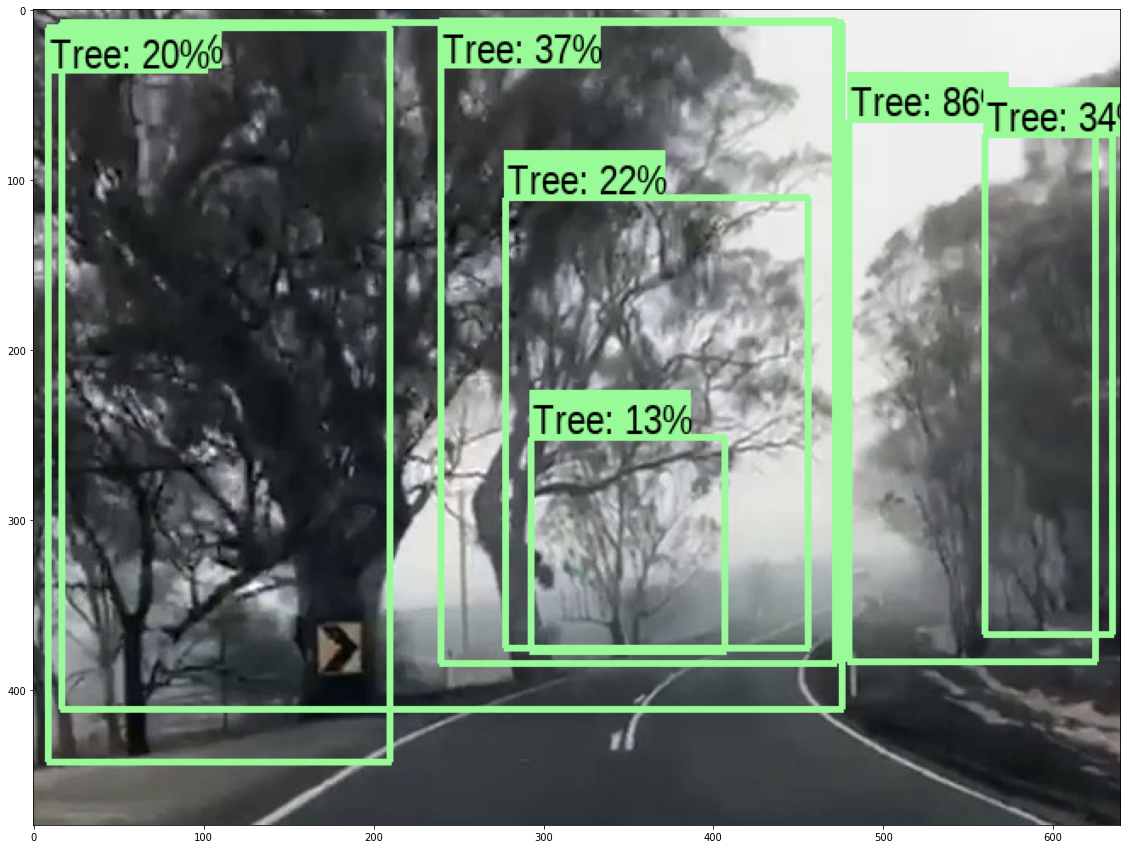

In [94]:
detect_img(image_urls[15])